## Import required libraries

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import time
import random
import re
import sys
import albumentations as A
from numba import jit
from matplotlib import pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn import metrics 
from scipy.ndimage import zoom

## Check information about GPU

In [2]:
!nvidia-smi

Fri Jun 10 20:12:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:09:00.0 Off |                  N/A |
| 27%   39C    P8    24W / 250W |   1514MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:0A:00.0 Off |                  N/A |
| 27%   

## Dataset class for our data

In [3]:
# to retrive one feature and lable one time
class SpikeletData(Dataset):
    def __init__(self, annotations_file, data_type='train', shuffle=False):
        
        # annotations file contains paths to images, labels, and belonging to the one of classes
        def data_target_split(file, data_type):
            x_data = []
            y_data = []
            with open(file) as inp:
                if shuffle:
                    data = [ (random.random(), line) for line in inp]
                    data.sort()
                    for _, line in data:
                        data = line.strip().split(';')
                        if data[2] == data_type:
                            x_data.append(data[0])
                            y_data.append(int(data[1]))
                else:
                    row = inp.readline().strip().split(';')
                    while len(row)>2:
                        if row[2] == data_type:
                            x_data.append(row[0])
                            y_data.append(int(row[1]))
                        row = inp.readline().strip().split(';')
            return x_data, y_data
                                  
        self.annotations_file = annotations_file
        self.data_type = data_type
        self.data, self.labels = data_target_split(annotations_file, data_type)
        
        
    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, idx):
        
        # expand image to square of required size
        def get_square(img, size):
            x,y,z = img.shape
            if y < size and x >= size:
                square = np.zeros((x, size, 3), dtype='int')
            
                # Getting the centering position
                ax,ay = (x - img.shape[0])//2,(size - y)//2
            
                # Pasting the 'image' in a centering position
                if y % 2 == 0:
                    square[ax:x,ay:size-ay] += img
                else:
                    square[ax:x,ay:size-1-ay] += img
                np.count_nonzero(square)*100/(x*y*z)
                return square
            elif x < size and y >= size:
                square = np.zeros((size, y, 3), dtype='int')
                
                # Getting the centering position
                ax,ay = (size - x)//2,(y - img.shape[1])//2
            
                # Pasting the 'image' in a centering position
                if x % 2 == 0:
                    square[ax:size-ax,ay:y] += img
                else:
                    square[ax:size-1-ax,ay:y] += img
                np.count_nonzero(square)*100/(x*y*z)
                return square
            elif x < size and y < size:
                square = np.zeros((size, size, 3), dtype='int')
                
                # Getting the centering position
                ax,ay = (size - x)//2,(size - y)//2
            
                # Pasting the 'image' in a centering position
                if x%2 == 0 and y%2 == 0:
                    square[ax:-ax,ay:size-ay] += img
                elif x%2 == 0 and  y%2 != 0:
                    square[ax:size-ax,ay:size-1-ay] += img
                elif x%2 != 0 and y%2 == 0:
                    square[ax:size-1-ax,ay:size-ay] += img
                else:
                    square[ax:size-1-ax,ay:size-1-ay] += img
                np.count_nonzero(square)*100/(x*y*z)
                return square
                
        
        # read image and get label using path to image    
        def get_crop(img_path):
            ploid_patt = r'(Гексаплоиды)|(Диплоиды)|(Тетраплоиды)'
            pin_patt = r'[\d]{2,5}_[^,(I|l)]_\{[XХI]+-?\d{2}\}\.(jpg|JPG)$'
            spec_patt = r'T\.\s[a-z]*'
            table_patt = r'[\d]{2,5}_\{[ХXI]+-?\d{2}\}\.(jpg|JPG)$'
            
            # get data of ploidness and species to open segemented image
            ploid = re.search(ploid_patt, img_path).group()
            spec = re.search(spec_patt, img_path).group()    
            img_type = 'pin'
            img_name = re.search(pin_patt, img_path)
            if not img_name:
                img_type = 'table'
                img_name = re.search(table_patt, img_path)
            img_name = img_name.group()
            
            inp_dir = f'/home/jupyter-n.artemenko/projects/spikelet_pubescence/crops_without_spine/{ploid}/{spec}/{img_type}/{img_name}'
            inp_dir = inp_dir.replace('.jpg', '.png').replace('.JPG', '.png')
            inp_img = cv2.imread(inp_dir)
            if inp_img is None:
                print(inp_dir)
                
            res = None
            
            # different augmentations for images according to type of data
            if self.data_type=='train':
                # the first stage of augmentations
                transform_1 = A.Compose([
                    A.Rotate(limit=30, p=0.5),
                    A.RandomScale((0.5, 1.5), p=0.7)
                ])
                
                transform_2 = A.Compose([
                    A.RandomCrop(640, 640),
                    A.Flip(p=0.4)
                ])
                
                out_img = transform_1(image=inp_img)['image']
                size = 640
                
                # get square, if scaled image smaller, than training size
                if out_img.shape[0] < size or out_img.shape[1] < size:
                    out_img = get_square(out_img, size)
                
                out_img = transform_2(image=out_img)['image']
                x,y,z = out_img.shape
                
                # we don't need in crops without spikelets, so we add condition to number of nonzero
                # to the number of nonzero pixels
                percent = np.count_nonzero(out_img)*100/(x*y*z)    # percent of nonzero pixels
                count = 0
                while percent < 15 and count<100:
                    count += 1
                    out_img = transform_1(image=inp_img)['image']
                    if out_img.shape[0] < size or out_img.shape[1] < size:
                        out_img = get_square(out_img, size)
                    out_img = transform_2(image=out_img)['image']
                    percent = np.count_nonzero(out_img)*100/(x*y*z)
            
                # the second stage of augmentations
                transform = A.Compose([
                    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
                ])
                
                out_img = out_img.astype(np.uint8)
                new_data = transform(image=out_img)
                res = new_data['image']
                
            elif self.data_type=='valid' or self.data_type=='test':
                size = 640
                res = inp_img.copy()
                if inp_img.shape[0] < size or inp_img.shape[1] < size:
                    res = get_square(inp_img, size)
                    
                transform = A.Compose([
                    A.CenterCrop(size,size)
                ])
                
                new_data = transform(image=res)
                res = new_data['image']
            else:
                print('''Error occured. Check your data_type and change to one of these:
                      \"train\", \"valid\" \"test\"''')
            
            # See the result
            # plt.imshow(res[:,:,::-1])
            
            # if you want to save obtained image
            # cv2.imwrite(f'/home/jupyter-n.artemenko/projects/spikelet_pubescence/test/{idx}.png', res)
            return res, spec
        
        current_sample = self.data[idx]
        current_target = self.labels[idx]
        img, species = get_crop(current_sample)
        
        # normalize image and move axis
        normalize = A.Compose([
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1.0)
        ])
        img_norm = normalize(image=img)['image']
        img_norm = np.moveaxis(img_norm, 2, 0)
        img = np.moveaxis(img, 2, 0)
        return torch.tensor(img_norm), current_target, idx, species.strip()

## Define datasets for further learning process

In [4]:
data_source = '/home/jupyter-n.artemenko/projects/spikelet_pubescence/sample_split_.txt'
train_data = SpikeletData(data_source, 'train')
valid_data = SpikeletData(data_source, 'valid')
test_data = SpikeletData(data_source, 'test')
dataset = torch.utils.data.ConcatDataset([train_data, valid_data, test_data])

### Evaluate time of extraction one image

In [5]:
start = time.time()
sample_dataset = train_data
idx = random.randrange(0, sample_dataset.__len__())
print(idx)
print(sample_dataset.__getitem__(idx)[3])
print(time.time()-start)

353
T. aestivum
0.31726503372192383


## Focal loss

In [6]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=1, alpha=1, reduction='none', size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)
        
        p = torch.sigmoid(input)
        ce_loss = F.binary_cross_entropy_with_logits(
            input, target, reduction="none"
        )
        p_t = p * target + (1 - p) * (1 - target)
        loss = ce_loss * ((1 - p_t) ** self.gamma)
        if self.alpha >= 0:
            alpha_t = self.alpha * target + (1 - self.alpha) * (1 - target)
            loss = alpha_t * loss

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss

## Class of model

In [7]:
class MyCNN():
    def __init__(self, model_name, save_path, loss):
        # load model
        self.model = torchvision.models.efficientnet_b1(pretrained=True)
        print(self.model.__dict__)
        self.model.classifier =  nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=1280, out_features=1),
            nn.Sigmoid())

        self.save_path = save_path.format(model_name = model_name)
        self.model_name = model_name
        self.optimizer = optim.Adam(self.get_params(), lr=1e-5, weight_decay=1e-3)
        # self.optimizer = optim.SGD(self.get_params(), lr=1e-9, momentum=0.9)
        self.loss = loss
        
        self.device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        
    # load weights of model
    def load(self):
        self.model.load_state_dict(torch.load(self.save_path))
        
    
    # gives parameters of model to optimization algorithms
    def get_params(self):
        return self.model.parameters()
    
    
    # show learning plots
    def training_data(self):
        try:
            data = pd.read_csv(self.save_path + '.csv')
            x_data = data['epoch'].tolist()
            figure, axs = plt.subplots(2, 2, figsize=(16, 10))
            
            # plot losses
            axs[0][0].set_title('Losses')
            y_data = data['training_loss'].tolist()
            axs[0][0].plot(x_data, y_data, color='black')
            y_data = data['valid_loss'].tolist()
            axs[0][0].plot(x_data, y_data, color='red')
            
            # plot accuracy
            axs[0][1].set_title('Accuracy')
            y_data = data['training_accuracy'].tolist()
            axs[0][1].plot(x_data, y_data, color='black', label = 'training')
            y_data = data['valid_accuracy'].tolist()
            axs[0][1].plot(x_data, y_data, color='red', label = 'valid')
            
            # plot precision
            axs[1][0].set_title('Precision')
            y_data = data['training_precision'].tolist()
            axs[1][0].plot(x_data, y_data, color='black', label = 'training')
            y_data = data['valid_precision'].tolist()
            axs[1][0].plot(x_data, y_data, color='red', label = 'valid')
            
            # plot auc
            axs[1][1].set_title('AUC')
            y_data = data['training_auc'].tolist()
            axs[1][1].plot(x_data, y_data, color='black', label = 'training')
            y_data = data['valid_auc'].tolist()
            axs[1][1].plot(x_data, y_data, color='red', label = 'valid')
            
            plt.legend()
        except FileNotFoundError:
            print("Please, check csv file with training loss and training data and path to it")
            
        
    @staticmethod
    def confusion_matrix(outputs, labels, threshold=0.5):
        # our confusion matrix will be look like |TN|FP|
        #                                        |FN|TP|
        matrix = np.zeros((2, 2), dtype=np.int16)
        for i in range(len(outputs)):
            # define prediction with threshold
            prediction = 1 if outputs[i].item() >= threshold else 0
            true_value = int(labels[i].item())
            matrix[true_value][prediction] += 1
        return matrix
        
      
    # show plots of species and predictions of model
    def show_errors(self, dataset):
        dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=16)
        species_dist = {}
        
        # we don't need in computing gradients and changing weights of model
        self.model.eval()
        with torch.no_grad():
            for (inputs, labels, idxs, spec) in dataloader:
                # move the input and model to GPU for speed if available
                inputs = inputs.float()            
                labels = labels.unsqueeze(1)
            
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
            
                outputs = self.model(inputs)
                outputs = outputs.to(self.device)
                if spec[0] not in species_dist.keys():
                    species_dist[spec[0]] = np.zeros((2,2), dtype=np.int16)
                    
                # fill species_dist
                prediciton = 1 if outputs.item() >= 0.5 else 0
                label = labels.item()
                species_dist[spec[0]][label][prediciton] += 1
                
        # plots with classification data
        figure, axs = plt.subplots(len(species_dist), 1, figsize=(10, 100))
        for i, name in enumerate(species_dist.keys()):
            tmp = species_dist[name]
            x = np.reshape(tmp, (4))
            labels =['TN', 'FN', 'FP', 'TP']
            TN, FN, FP, TP = x
            accuracy = (TN + TP)/x.sum()
            # print(f'for species {name} we have: \n TN: {x[0]} \n FP: {x[1]}\n FN: {x[2]}\n TP: {x[3]}\n')
            print(f'for species {name} we have accuracy: {accuracy}')
            rect = axs[i].bar(labels, x, color='orange')
            axs[i].set_xlabel(name) 
            
            
    def class_activation_map(self, img, target):
        img_tensor = img.unsqueeze(0)
        img_tensor = img_tensor.to(self.device)
        
        output = self.model(img_tensor)
        conv_output = self.model.features(img_tensor)    # output of model before pooling
        
        prediction = 1 if output.item() >= 0.5 else 0
        
        # load weights if model was trained
        if os.path.exists(self.save_path):
            self.model.load_state_dict(torch.load(self.save_path))
            
        # extract weigts of the last layer before pooling
        w = 0
        for layer in list(self.model.named_parameters()):
            if layer[0] == 'features.8.1.weight':
                w = layer[1].cpu().detach().numpy()
            
        # acuire heatmap
        conv = conv_output.squeeze().cpu().detach().numpy()
        heatmap = 0
        for i in range(conv.shape[0]):
            heatmap += w[i]*conv[i]
        
        scale = 512 / 16
        plt.figure(figsize=(12, 12))
        
        img = img.detach().numpy()
        res = np.moveaxis(img, 0, 2)
        plt.imshow(res[:,:,::-1])
        plt.imshow(zoom(heatmap, zoom=(scale, scale)), cmap='jet', alpha=0.5)
        print(f"Target is: {target}", f"Prediction is: {prediction}", sep='\n')
                
        
    def run_epoch(self, dataloader, batch_sizes, data_type, threshold=0.5):
        # main variables
        running_loss = 0.0
        conf_matrix = np.zeros((2,2), dtype = np.int16)
        auc_matrices = np.zeros((11,2,2), dtype=np.int16)
        
        def auc_metric(matrices):
            True_Positive_Rate = []
            False_Positive_Rate = []
            for matrix in matrices:
                # TPR, FPR
                True_Positive_Rate.append(matrix[1][1]/(matrix[1][1] + matrix[1][0]))
                False_Positive_Rate.append(matrix[0][1]/(matrix[0][0] + matrix[0][1]))
                    
            AUC = 0
            for i in range(len(False_Positive_Rate)-1):
                l = (True_Positive_Rate[i+1]+True_Positive_Rate[i])/2
                h = False_Positive_Rate[i]-False_Positive_Rate[i+1]
                AUC += h*l
            return AUC
        
        def dataloader_loop():
            for (inputs, labels, idxs, spec) in dataloader:
                nonlocal running_loss, conf_matrix, auc_matrices
                # move the input and model to GPU for speed if available
                inputs = inputs.float()
                labels = labels.unsqueeze(1)
                labels = labels.float()
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                    
                outputs = self.model(inputs)
                outputs = outputs.to(self.device)
                loss = self.loss(outputs, labels)
                # backpropogating when on train data
                if data_type == 'train':
                    loss.backward()
                    self.optimizer.step()
                # compute auc
                for i in range(0,11):
                    tmp = self.confusion_matrix(outputs, labels, 0.1*i)
                    auc_matrices[i] += tmp
                    
                running_loss += loss.item()
                conf_matrix += self.confusion_matrix(outputs, labels, threshold)
        
        
        # preliminary preparation for loop
        if data_type == 'valid' or data_type == 'test':
            self.model.eval()
            with torch.no_grad():
                dataloader_loop()
        elif data_type == 'train':
            self.model.train()  
            dataloader_loop()
           
        # compute metrics and loss
        TP = conf_matrix[1][1]
        TN = conf_matrix[0][0]
        FP = conf_matrix[0][1]
        FN = conf_matrix[1][0]
        accuracy = (TP + TN)/(TP + FP + TN + FN)
        if TP + FP != 0:
            precision = TP/(TP + FP)
        else:
            precision = 0
        # print(auc_matrices)
        print(conf_matrix)
        auc = auc_metric(auc_matrices)
        loss = 0
        if data_type == 'valid' or data_type == 'test':
            loss = running_loss*batch_sizes[1]
        else:
            loss = running_loss*batch_sizes[0]
        
        # average loss by data_type
        if data_type == 'valid':
            loss = loss/valid_data.__len__()
        elif data_type == 'test':
            loss = loss/test_data.__len__()
        elif data_type == 'train':
            loss = loss/train_data.__len__()
        return loss, accuracy, precision, auc
    
    
    def fit(self, batch_sizes, epochs=10):      
        # we need to save information about learning process
        learning_data = {'epoch': [], 'training_loss': [], 'training_accuracy': [],
                        'training_precision': [], 'training_auc': [],'valid_loss': [], 
                         'valid_accuracy': [], 'valid_precision': [], 'valid_auc': []}
        
        # training loop
        train_generator = DataLoader(dataset=train_data, batch_size=batch_sizes[0], shuffle=True, num_workers=16)
        valid_generator = DataLoader(dataset=valid_data, batch_size=batch_sizes[1], shuffle=False, num_workers=16)
        for epoch in range(1, epochs+1):
            print(f'Epoch number: {epoch}')       
            # run training process and get data
            train_loss, train_accuracy, train_precision, train_auc = self.run_epoch(train_generator, 
                                                                            batch_sizes, data_type='train')
            
            valid_loss, valid_accuracy, valid_precision, valid_auc = self.run_epoch(valid_generator, 
                                                                            batch_sizes, data_type='valid')
                
            # write data to the table
            learning_data['epoch'].append(epoch)
            learning_data['training_loss'].append(train_loss)
            learning_data['training_accuracy'].append(train_accuracy)
            learning_data['training_precision'].append(train_precision)
            learning_data['training_auc'].append(train_auc)
            
            learning_data['valid_loss'].append(valid_loss)
            learning_data['valid_accuracy'].append(valid_accuracy)
            learning_data['valid_precision'].append(valid_precision)
            learning_data['valid_auc'].append(valid_auc)
            
            # print statistics
            print('Training data:  [%d] epoch,  loss: %.5f, accuracy: %.5f, precision: %.5f, auc: %.5f'%
                    (epoch, train_loss, train_accuracy, train_precision, train_auc))
            print('Valid data:  [%d] epoch,  loss: %.5f, accuracy: %.5f precision: %.5f, auc: %.5f' %
                    (epoch, valid_loss, valid_accuracy, valid_precision, valid_auc))
            torch.save(self.model.state_dict(), self.save_path)
            tmp = pd.DataFrame(learning_data)
            tmp.to_csv(self.save_path + '.csv')

        print('Finished Training')

### **Define learning parameters**

In [8]:
project_dir = '/home/jupyter-n.artemenko/projects/spikelet_pubescence'
train_batch_size = 8
inference_batch_size = 16
epochs = 40
criterion = nn.BCELoss()
# criterion = FocalLoss(reduction = 'sum')
# optimizer = optim.SGD(model.get_params(), lr=1e-7, momentum=0.7, weight_decay=1e-5)

### **Define model**

In [9]:
model = MyCNN('efficientnet_b1', 
              project_dir + '/models/AugCrops_128x128/100_epochs_{model_name}_lr1e-5_CentCrop_wd1e-3_512x512'
                ,criterion)

{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_modules': OrderedDict([('features', Sequential(
  (0): ConvNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avg

### **Tarin our model**

In [10]:
# model.fit(batch_sizes=(train_batch_size, inference_batch_size), epochs=epochs)

### **Evaluating our model**

In [11]:
model.load()

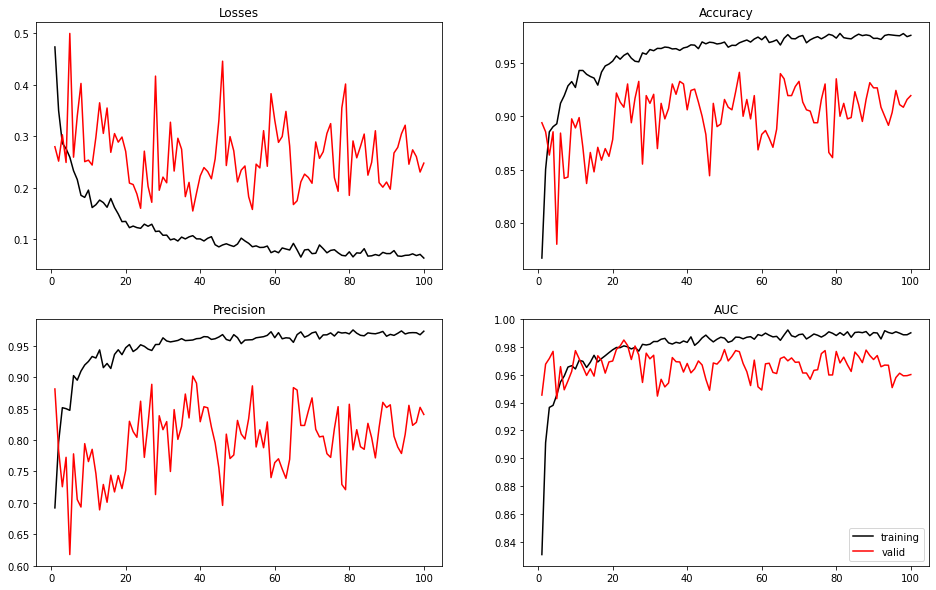

In [12]:
model.training_data()

### Results on valid and test subsets

In [13]:
valid = DataLoader(dataset=valid_data, batch_size=inference_batch_size, shuffle=False, num_workers=16)
test = DataLoader(dataset=test_data, batch_size=inference_batch_size, shuffle=False, num_workers=16)

In [14]:
model.run_epoch(valid,(train_batch_size, inference_batch_size), data_type='valid')

[[799   8]
 [  6 404]]


(0.039451298800508676, 0.9884963, 0.98058254, 0.9982228820076717)

In [15]:
model.run_epoch(test,(train_batch_size, inference_batch_size), data_type='valid')

[[458 102]
 [ 30 439]]


(0.24048549863347693, 0.87172014, 0.81146026, 0.9570629151736594)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target is: 0
Prediction is: 0


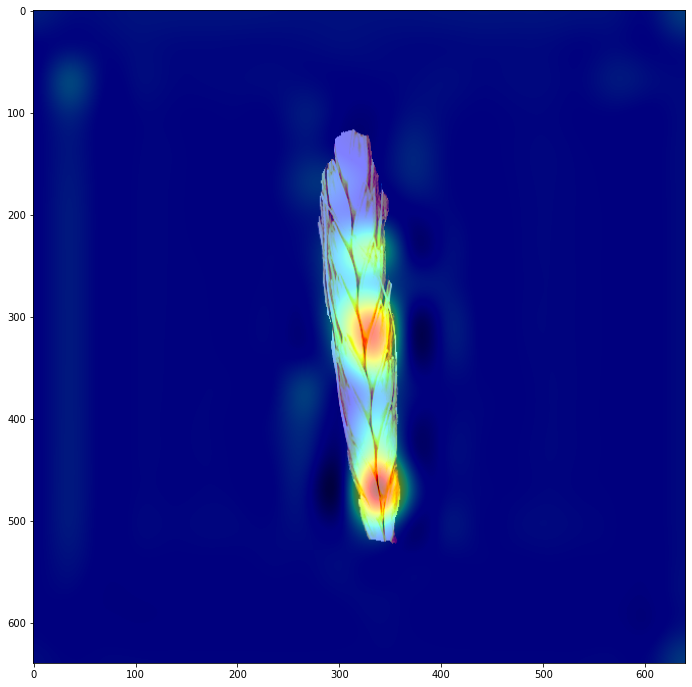

In [16]:
img, target, _, _ = test_data.__getitem__(359)
model.class_activation_map(img, target)

for species T. aethiopicum we have accuracy: 0.9907692307692307
for species T. turgidum we have accuracy: 0.9915254237288136
for species T. monococcum we have accuracy: 0.8
for species T. yunnanense we have accuracy: 1.0
for species T. dicoccum we have accuracy: 0.992797118847539
for species T. timopheevii we have accuracy: 0.9017142857142857
for species T. polonicum we have accuracy: 0.9175757575757576
for species T. durum we have accuracy: 0.9871205151793928
for species T. aestivum we have accuracy: 0.9796610169491525
for species T. dicoccoides we have accuracy: 0.8497409326424871
for species T. petropavlovskyi we have accuracy: 0.9973262032085561
for species T. macha we have accuracy: 0.976
for species T. carthlicum we have accuracy: 0.9707317073170731
for species T. compactum we have accuracy: 1.0
for species T. spelta we have accuracy: 1.0
for species T. boeoticum we have accuracy: 0.7448275862068966
for species T. vavilovii we have accuracy: 0.7272727272727273
for species T. urar

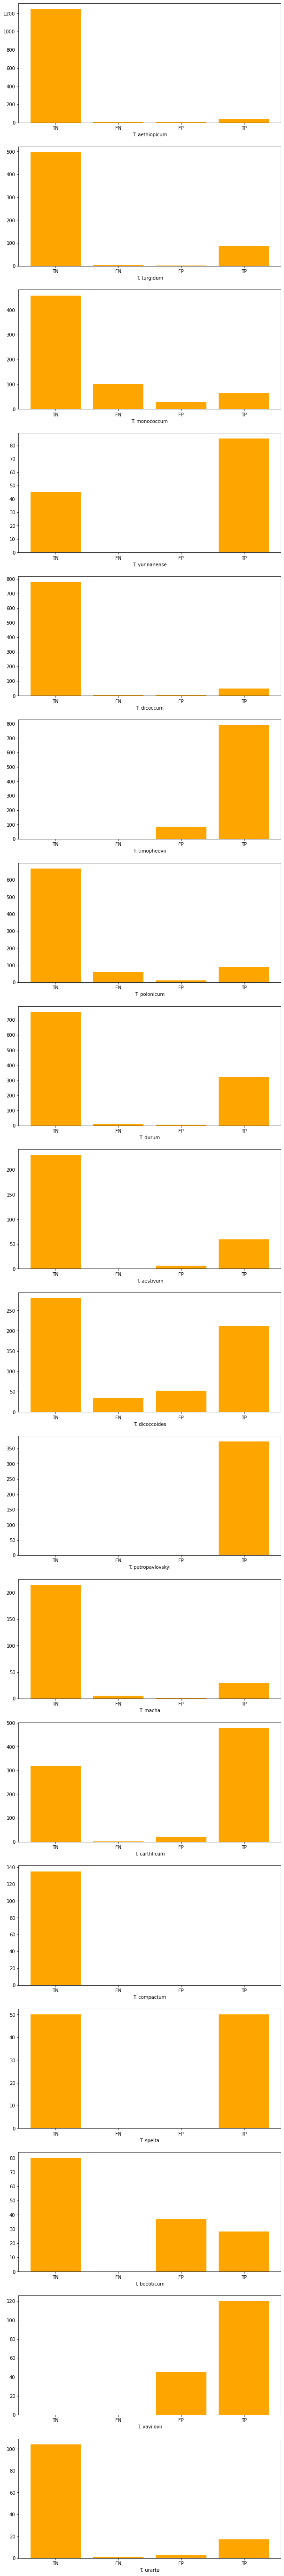

In [17]:
model.show_errors(dataset)